In [1]:
#hide
import causalnlp

# CausalNLP

> CausalNLP is a practical toolkit for causal inference with text.

## Install

1. `pip install -U pip`
2. `pip install causalnlp`

## Usage

### What is the causal impact of a positive review on a product click?

In [2]:
import pandas as pd
df = pd.read_csv('sample_data/music_seed50.tsv', sep='\t', error_bad_lines=False)

The file `music_seed50.tsv` is a semi-simulated dataset from [here](https://github.com/rpryzant/causal-text). Columns of relevance include:
- `Y_sim`: simulated outcome, where 1 means product was clicked and 0 means not. 
- `C_true`:confounding categorical variable (1=audio CD, 0=other)
- `T_true`: 1 means rating less than 3, 0 means rating of 5, where `T_true` affects the outcome `Y_sim`.
- `T_ac`: An approximation of true review sentiment (`T_true`) created with `Autocoder`.

We'll pretend the rating and `T_true` are unobserved and only use `T_ac` as the treatment variable. Using the `text_col` parameter, we include raw text as covariates for which adjustments can be made to improve causal estimates.

In [3]:
from causalnlp.causalinference import CausalInferenceModel
from lightgbm import LGBMClassifier
cm = CausalInferenceModel(df, 
                         metalearner_type='t-learner', learner=LGBMClassifier(num_leaves=500),
                         treatment_col='T_ac', outcome_col='Y_sim', text_col='text',
                         include_cols=['C_true'])
cm.fit()

outcome column (categorical): Y_sim
treatment column: T_ac
numerical/categorical covariates: ['C_true']
text covariate: text
preprocess time:  1.1211283206939697  sec
start fitting causal inference model
time to fit causal inference model:  10.984754800796509  sec


The average treatment effect (ATE):

In [4]:
cm.estimate_ate()

{'ate': 0.1309311542209525}

The conditional average treatment effect (CATE) for those reviews that mention the word "toddler":

In [5]:
cm.estimate_ate(df['text'].str.contains('toddler'))

{'ate': 0.15559234254638685}

Features most predictive of the treatment effects (e.g., increase in probability of clicking product):

In [6]:
cm.interpret(plot=False)[1][:10]

v_music    0.079042
v_cd       0.066838
v_album    0.055168
v_like     0.040784
v_love     0.040635
C_true     0.039949
v_just     0.035671
v_song     0.035362
v_great    0.029918
v_heard    0.028373
dtype: float64

Features with the `v_` prefix are word features. `C_true` is the categorical variable indicating whether or not the product is a CD.

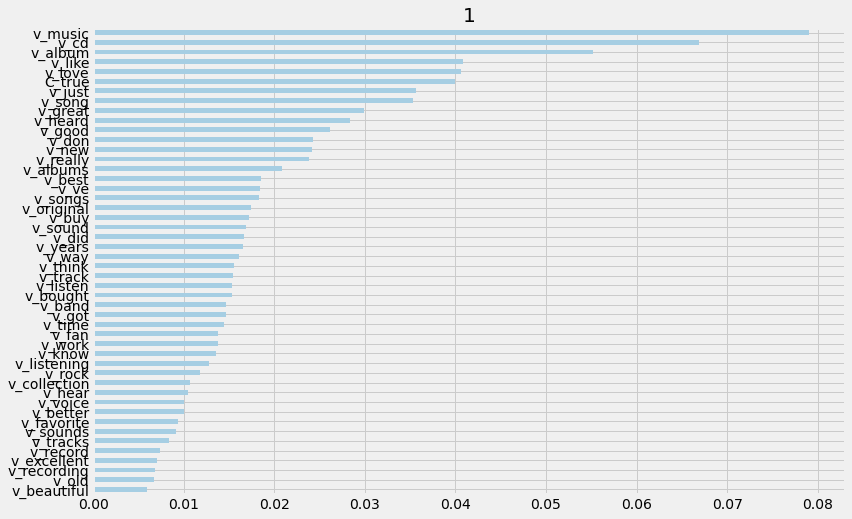

In [10]:
cm.interpret(plot=True)